<a href="https://colab.research.google.com/github/victorhcunha/ultima-atividade-ia/blob/main/studentsperformance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importação de Bibliotecas

In [ ]:
#dados
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
#metricas
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
#modelos
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
#renderização
import pydot
import graphviz
from ipywidgets import interactive
from IPython.display import SVG,display
from graphviz import Source



##Carregando Base de Dados

In [ ]:
data = pd.read_csv("StudentsPerformance.csv")

data.info()
print(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
     gender race/ethnicity  ... reading score writing score
0    female        group B  ...            72            74
1    female        group C  ...            90            88
2    female        group B  ...            95            93
3      male        group A  ...   

##Tratamento de dados

In [ ]:
# Removendo as colunas de raça e gênero (que não serão usadas)
data.drop(['race/ethnicity', 'gender'], axis=1, inplace=True)

# Deixando os valotes de 'test preparation course' em binário (1 -> completed)
data.loc[(data['test preparation course'] == 'none'), 'test preparation course'] = 0
data.loc[(data['test preparation course'] == 'completed'), 'test preparation course'] = 1

# Deixando os valotes de 'lunch' em binário (1 -> free/reduced)
data.loc[(data['lunch'] == 'standard'), 'lunch'] = 0
data.loc[(data['lunch'] == 'free/reduced'), 'lunch'] = 1

# Transformando os valores de 'parental level of education' em numerais ordenados
data.loc[(data['parental level of education'] == 'some high school'), 'parental level of education'] = 1
data.loc[(data['parental level of education'] == 'high school'), 'parental level of education'] = 2
data.loc[(data['parental level of education'] == 'some college'), 'parental level of education'] = 3
data.loc[(data['parental level of education'] == "associate's degree"), 'parental level of education'] = 4
data.loc[(data['parental level of education'] == "bachelor's degree"), 'parental level of education'] = 5
data.loc[(data['parental level of education'] == "master's degree"), 'parental level of education'] = 6

# Agrupando as notas de 'writing score' para a classificação (1-> notas mais baixas ... 4-> notas mais altas)
data.loc[(data['writing score'] < 40), 'writing score'] = 1
data.loc[(data['writing score'] >= 40) & (data['writing score'] < 60), 'writing score'] = 2
data.loc[(data['writing score'] >= 60) & (data['writing score'] < 80), 'writing score'] = 3
data.loc[(data['writing score'] >= 80), 'writing score'] = 4


print(data)

    parental level of education lunch  ... reading score  writing score
0                             5     0  ...            72              3
1                             3     0  ...            90              4
2                             6     0  ...            95              4
3                             4     1  ...            57              2
4                             3     0  ...            78              3
..                          ...   ...  ...           ...            ...
995                           6     0  ...            99              4
996                           2     1  ...            55              2
997                           2     1  ...            71              3
998                           3     0  ...            78              3
999                           3     1  ...            86              4

[1000 rows x 6 columns]


##Divisão de dados (treino x teste)

In [ ]:
features = ['parental level of education','lunch', 'test preparation course','math score','reading score']
valuesFeatures = data[features].values
valuesClass = data['writing score'].values

# Mostrando os valores
print(valuesClass)
print(valuesFeatures)

[3 4 4 2 3 3 4 1 3 2 2 2 3 3 2 3 4 1 2 3 3 3 2 3 4 3 2 3 3 3 3 3 3 1 4 3 4
 2 4 2 2 3 3 3 2 2 3 3 3 4 2 3 2 3 4 2 4 2 2 1 3 1 2 3 2 3 1 3 2 2 3 3 2 2
 2 1 1 4 3 3 2 2 2 3 1 4 4 3 3 4 3 1 3 2 4 4 3 3 3 3 3 3 4 2 4 3 4 3 3 3 4
 2 2 2 4 3 4 3 3 3 4 4 4 2 3 4 3 3 3 2 4 2 3 4 3 2 2 2 3 3 3 3 2 2 3 1 3 3
 4 4 3 3 3 2 3 4 3 3 4 3 3 4 2 2 4 4 2 3 3 3 3 3 4 3 2 4 2 3 3 4 3 3 2 3 2
 3 3 3 2 4 3 3 3 3 4 2 3 2 2 3 4 3 3 3 2 3 3 3 3 3 3 1 3 2 4 3 4 1 3 2 3 3
 3 3 3 2 3 2 3 4 3 2 4 3 4 3 3 3 2 4 3 4 2 2 3 3 3 3 3 2 2 4 3 3 2 3 3 3 3
 4 3 3 2 4 3 2 4 3 4 3 3 2 2 3 3 3 4 3 4 2 2 2 4 3 2 4 4 4 3 3 3 3 2 3 4 3
 2 3 2 3 4 2 4 3 4 3 4 2 3 2 4 2 3 3 3 3 4 3 3 3 4 3 4 2 2 4 3 1 3 2 3 1 2
 4 4 3 3 2 1 3 2 3 3 3 3 3 2 4 3 3 3 2 4 2 3 3 3 3 3 4 2 3 2 1 2 3 2 3 2 4
 3 3 3 4 3 2 4 4 3 3 4 4 3 2 2 3 3 3 3 3 2 3 3 2 3 2 3 4 2 2 3 2 2 4 3 3 3
 3 2 4 3 3 3 3 3 3 3 3 3 2 4 3 3 4 1 3 4 3 2 2 2 3 2 2 3 2 3 3 2 4 3 4 3 3
 3 3 3 4 2 3 4 4 3 2 3 2 4 2 4 3 2 2 3 4 3 4 1 3 4 3 4 3 4 3 4 4 3 3 3 3 3
 2 3 2 2 3 2 3 2 4 3 3 4 

In [ ]:
# Dividindo os dados em treino e teste:
X_train, X_test, y_train, y_test = train_test_split(valuesFeatures,valuesClass,test_size=0.30) #30% para teste

# Mostrando a forma dos dados:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(700, 5) (300, 5)
(700,) (300,)


##Árvore de Decisão

In [ ]:
# Instânciando o objeto classificador:
classifier = DecisionTreeClassifier()

# Treinando o modelo de arvore de decisão:
classifier = classifier.fit(X_train,y_train)

# Verificando os atributos mais importantes/relevantes para o modelo treinado:
print(classifier.feature_importances_)

for feature,importancia in zip(data.columns,classifier.feature_importances_):
    print("{}: {}".format(feature, importancia))

#Verificando a acurácia do modelo
y_pred = classifier.predict(X_test)
acuracia = accuracy_score(y_test, y_pred)
print('A acurácia do modelo é igual a ' + str(acuracia))

[0.06955922 0.02707184 0.03526484 0.12899165 0.73911246]
parental level of education: 0.069559218406698
lunch: 0.027071835537625825
test preparation course: 0.035264838757968375
math score: 0.12899164767659588
reading score: 0.7391124596211118
A acurácia do modelo é igual a 0.7866666666666666


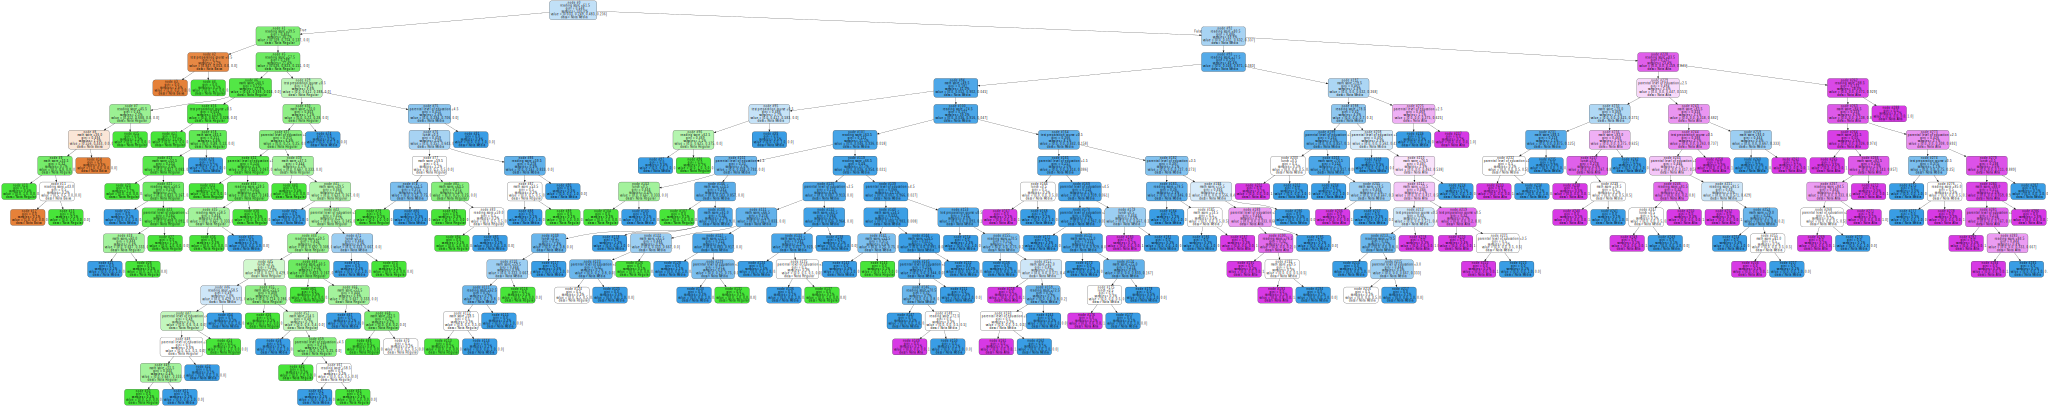

In [ ]:
# Renderização de Árvore:
dot_data = export_graphviz( 
         classifier, 
         out_file=None,
         feature_names= features,
         class_names=['Nota Baixa','Nota Regular', 'Nota Média', 'Nota Alta'],  
         filled=True, rounded=True,
         proportion=True,
         node_ids=True,
         rotate=False,
         label='all',
         special_characters=True
        )


graph = graphviz.Source(dot_data)  
graph

##Árvore de Decisão Interativa

In [ ]:
# Renderizando árvore interativa

def arvoreinterativa(crit, split, depth, min_samples_split, min_samples_leaf=0.2):
    estimator = DecisionTreeClassifier(
           random_state = 0 
          ,criterion = crit
          ,splitter = split
          ,max_depth = depth
          ,min_samples_split=min_samples_split
          ,min_samples_leaf=min_samples_leaf
    )
    estimator.fit(X_train,y_train)
    graph = Source(export_graphviz(estimator
      , out_file=None
      , feature_names=features
      , class_names=['Nota Baixa','Nota Regular', 'Nota Média', 'Nota Alta']
      , impurity=True
      , filled = True))
    display(SVG(graph.pipe(format='svg')))

    #importancia
    for feature,importancia in zip(data.columns,estimator.feature_importances_):
      print("{}: {}".format(feature, importancia))
    #Verificando a acurácia do modelo
    y_pred = estimator.predict(X_test)
    acuracia = accuracy_score(y_test, y_pred)
    print('A acurácia do modelo é igual a ' + str(acuracia))

    return estimator


inter=interactive(arvoreinterativa 
   , crit = ["gini", "entropy"]
   , split = ["best", "random"]
   , depth=[1,2,3,4,5,10,20,30]
   , min_samples_split=(1,5)
   , min_samples_leaf=(1,5))

display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

## KNN


In [ ]:
y_pred = "" #Garantir que não haja influencia de outros modelos

# Instanciando o crasificador (k = 3)
classifier = KNeighborsClassifier(n_neighbors=3)

# Treinando o modelo
classifier.fit(X_train, y_train)

# Fazendo a previsão os dados de teste
y_pred = classifier.predict(X_test)


#Calculando a acurácia
acuracia = accuracy_score(y_test, y_pred)
print('A acurácia do modelo é igual a ' + str(acuracia))

A acurácia do modelo é igual a 0.8333333333333334


In [ ]:
for i in [1, 3, 5, 7, 9]:
  classifier = KNeighborsClassifier(n_neighbors=i)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  acuracia = accuracy_score(y_test, y_pred)
  print('A acurácia do modelo para k=' + str(i) + ' é igual a ' + str(acuracia))


A acurácia do modelo para k=1 é igual a 0.8233333333333334
A acurácia do modelo para k=3 é igual a 0.8333333333333334
A acurácia do modelo para k=5 é igual a 0.8333333333333334
A acurácia do modelo para k=7 é igual a 0.82
A acurácia do modelo para k=9 é igual a 0.8233333333333334


##Random Forests

In [ ]:
y_pred = "" #Garantir que não haja influencia de outros modelos

#Criando Árvore Aleatoria
clf=RandomForestClassifier(n_estimators=100)

#Treinando o Modelo
clf.fit(X_train,y_train)

#Ralizando a previsão
y_pred=clf.predict(X_test)

#Features mais Importantes
for feature,importancia in zip(data.columns,clf.feature_importances_):
    print("{}: {}".format(feature, importancia))

#Calculando a acurácia da previsão
acuracia = accuracy_score(y_test, y_pred)
print('A acurácia do modelo é igual a ' + str(acuracia))


parental level of education: 0.0684688492838511
lunch: 0.02038080253703302
test preparation course: 0.03162559818336128
math score: 0.25177212059208925
reading score: 0.6277526294036654
A acurácia do modelo é igual a 0.8


In [ ]:
y_pred = "" #Garantir que não haja influencia de outros modelos

for i in [100,200,500,800,1000,2000,3000]:
  #Criando Árvore Aleatoria
  clf=RandomForestClassifier(n_estimators=i)

  #Treinando o Modelo
  clf.fit(X_train,y_train)

  #Ralizando a previsão
  y_pred=clf.predict(X_test)

  #Calculando a acurácia da previsão e a importância das features
  for feature,importancia in zip(data.columns,clf.feature_importances_):
      print("{}: {}".format(feature, importancia))

  acuracia = accuracy_score(y_test, y_pred)
  print('A acurácia do modelo para árvores=' + str(i) + ' é igual a ' + str(acuracia))
  print('\n')

parental level of education: 0.06971620471593268
lunch: 0.020006147476033454
test preparation course: 0.03088562394035694
math score: 0.2513342246516049
reading score: 0.6280577992160721
A acurácia do modelo para árvores=100 é igual a 0.8066666666666666


parental level of education: 0.07064837523399628
lunch: 0.02056329880684462
test preparation course: 0.031259391575499874
math score: 0.25571139249607794
reading score: 0.6218175418875814
A acurácia do modelo para árvores=200 é igual a 0.8133333333333334


parental level of education: 0.06964506862557968
lunch: 0.019477182508390697
test preparation course: 0.031435584999392197
math score: 0.26828710241175896
reading score: 0.6111550614548785
A acurácia do modelo para árvores=500 é igual a 0.8066666666666666


parental level of education: 0.07073715297625566
lunch: 0.019336855831046936
test preparation course: 0.03195348788292918
math score: 0.2649028438048698
reading score: 0.6130696595048984
A acurácia do modelo para árvores=800 é ig

##Máquinas de Vetor de Suporte

In [ ]:
y_pred = "" #Garantir que não haja influencia de outros modelos

svc = SVC(kernel="linear")
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)


#Calculando a acurácia
acuracia = accuracy_score(y_test, y_pred)
print('A acurácia do modelo é igual a ' + str(acuracia))


A acurácia do modelo é igual a 0.8366666666666667


In [ ]:
for i in ['linear', 'poly', 'rbf']:
  y_pred = "" #Garantir que não haja influencia de outros modelos

  svc = SVC(kernel=i)
  svc.fit(X_train, y_train)
  y_pred = svc.predict(X_test)


  #Calculando a acurácia
  acuracia = accuracy_score(y_test, y_pred)
  print('A acurácia do modelo é igual a ' + str(acuracia))

A acurácia do modelo é igual a 0.8366666666666667
A acurácia do modelo é igual a 0.8333333333333334
A acurácia do modelo é igual a 0.8433333333333334


#Removendo "lunch" e "test preparation course"




In [ ]:

data.drop(['lunch', 'test preparation course'], axis=1, inplace=True)
features = ['parental level of education','math score','reading score']
valuesFeatures = data[features].values
valuesClass = data['writing score'].values

# Dividindo os dados em treino e teste:
X_train, X_test, y_train, y_test = train_test_split(valuesFeatures,valuesClass,test_size=0.30) #30% para teste

# Mostrando a forma dos dados:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(700, 3) (300, 3)
(700,) (300,)


##Árvore de Decisão

In [ ]:
# Instânciando o objeto classificador:
classifier = DecisionTreeClassifier()

# Treinando o modelo de arvore de decisão:
classifier = classifier.fit(X_train,y_train)

# Verificando os atributos mais importantes/relevantes para o modelo treinado:
print(classifier.feature_importances_)

for feature,importancia in zip(data.columns,classifier.feature_importances_):
    print("{}: {}".format(feature, importancia))

#Verificando a acurácia do modelo
y_pred = classifier.predict(X_test)
acuracia = accuracy_score(y_test, y_pred)
print('A acurácia do modelo é igual a ' + str(acuracia))

[0.08103161 0.18212215 0.73684625]
parental level of education: 0.08103160697959019
math score: 0.18212214618645972
reading score: 0.7368462468339501
A acurácia do modelo é igual a 0.8066666666666666


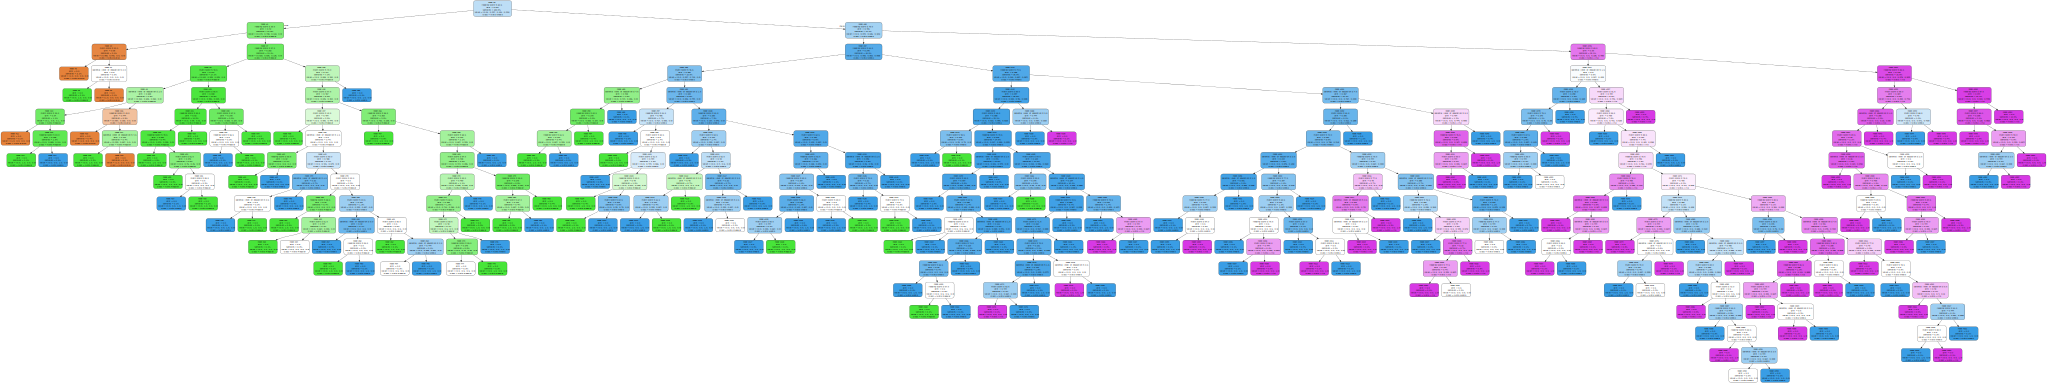

In [ ]:
# Renderização de Árvore:
dot_data = export_graphviz( 
         classifier, 
         out_file=None,
         feature_names= features,
         class_names=['Nota Baixa','Nota Regular', 'Nota Média', 'Nota Alta'],  
         filled=True, rounded=True,
         proportion=True,
         node_ids=True,
         rotate=False,
         label='all',
         special_characters=True
        )


graph = graphviz.Source(dot_data)  
graph

##Árvore de Decisão Interativa

In [ ]:
# Renderizando árvore interativa

def arvoreinterativa(crit, split, depth, min_samples_split, min_samples_leaf=0.2):
    estimator = DecisionTreeClassifier(
           random_state = 0 
          ,criterion = crit
          ,splitter = split
          ,max_depth = depth
          ,min_samples_split=min_samples_split
          ,min_samples_leaf=min_samples_leaf
    )
    estimator.fit(X_train,y_train)
    graph = Source(export_graphviz(estimator
      , out_file=None
      , feature_names=features
      , class_names=['Nota Baixa','Nota Regular', 'Nota Média', 'Nota Alta']
      , impurity=True
      , filled = True))
    display(SVG(graph.pipe(format='svg')))

    #importancia
    for feature,importancia in zip(data.columns,estimator.feature_importances_):
      print("{}: {}".format(feature, importancia))
    #Verificando a acurácia do modelo
    y_pred = estimator.predict(X_test)
    acuracia = accuracy_score(y_test, y_pred)
    print('A acurácia do modelo é igual a ' + str(acuracia))

    return estimator


inter=interactive(arvoreinterativa 
   , crit = ["gini", "entropy"]
   , split = ["best", "random"]
   , depth=[1,2,3,4,5,10,20,30]
   , min_samples_split=(1,5)
   , min_samples_leaf=(1,5))

display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

##KNN



In [ ]:
y_pred = "" #Garantir que não haja influencia de outros modelos

# Instanciando o crasificador (k = 3)
classifier = KNeighborsClassifier(n_neighbors=3)

# Treinando o modelo
classifier.fit(X_train, y_train)

# Fazendo a previsão os dados de teste
y_pred = classifier.predict(X_test)


#Calculando a acurácia
acuracia = accuracy_score(y_test, y_pred)
print('A acurácia do modelo é igual a ' + str(acuracia))

A acurácia do modelo é igual a 0.8433333333333334


In [ ]:
for i in [1, 3, 5, 7, 9]:
  classifier = KNeighborsClassifier(n_neighbors=i)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  acuracia = accuracy_score(y_test, y_pred)
  print('A acurácia do modelo para k=' + str(i) + ' é igual a ' + str(acuracia))

A acurácia do modelo para k=1 é igual a 0.8033333333333333
A acurácia do modelo para k=3 é igual a 0.8433333333333334
A acurácia do modelo para k=5 é igual a 0.84
A acurácia do modelo para k=7 é igual a 0.8433333333333334
A acurácia do modelo para k=9 é igual a 0.8566666666666667


##Random Forests

In [ ]:
y_pred = "" #Garantir que não haja influencia de outros modelos

#Criando Árvore Aleatoria
clf=RandomForestClassifier(n_estimators=100)

#Treinando o Modelo
clf.fit(X_train,y_train)

#Ralizando a previsão
y_pred=clf.predict(X_test)

#Calculando a acurácia da previsão
acuracia = accuracy_score(y_test, y_pred)
print('A acurácia do modelo é igual a ' + str(acuracia))

A acurácia do modelo é igual a 0.83


In [ ]:
y_pred = "" #Garantir que não haja influencia de outros modelos

for i in [100,200,500,800,1000,2000,3000]:
  #Criando Árvore Aleatoria
  clf=RandomForestClassifier(n_estimators=i)

  #Treinando o Modelo
  clf.fit(X_train,y_train)

  #Ralizando a previsão
  y_pred=clf.predict(X_test)

  #Calculando a acurácia da previsão e a importância das features
  for feature,importancia in zip(data.columns,clf.feature_importances_):
      print("{}: {}".format(feature, importancia))

  acuracia = accuracy_score(y_test, y_pred)
  print('A acurácia do modelo para árvores=' + str(i) + ' é igual a ' + str(acuracia))
  print('\n')

parental level of education: 0.06078535906828809
math score: 0.3319794847981852
reading score: 0.6072351561335266
A acurácia do modelo para árvores=100 é igual a 0.8366666666666667


parental level of education: 0.06316692040421984
math score: 0.32031486288127686
reading score: 0.6165182167145032
A acurácia do modelo para árvores=200 é igual a 0.83


parental level of education: 0.06222534669952118
math score: 0.3251630836602394
reading score: 0.6126115696402393
A acurácia do modelo para árvores=500 é igual a 0.8333333333333334


parental level of education: 0.06432480603005256
math score: 0.3223284076080934
reading score: 0.613346786361854
A acurácia do modelo para árvores=800 é igual a 0.83


parental level of education: 0.062318561636242054
math score: 0.3208523798239583
reading score: 0.6168290585397995
A acurácia do modelo para árvores=1000 é igual a 0.8366666666666667


parental level of education: 0.06244006478335014
math score: 0.3218591566039556
reading score: 0.61570077861269

##Máquinas de Vetor de Suporte

In [ ]:
y_pred = "" #Garantir que não haja influencia de outros modelos

svc = SVC(kernel="linear")
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)


#Calculando a acurácia
acuracia = accuracy_score(y_test, y_pred)
print('A acurácia do modelo é igual a ' + str(acuracia))


A acurácia do modelo é igual a 0.87


In [ ]:
for i in ['linear', 'poly', 'rbf']:
  y_pred = "" #Garantir que não haja influencia de outros modelos

  svc = SVC(kernel=i)
  svc.fit(X_train, y_train)
  y_pred = svc.predict(X_test)


  #Calculando a acurácia
  acuracia = accuracy_score(y_test, y_pred)
  print('A acurácia do modelo é igual a ' + str(acuracia))

A acurácia do modelo é igual a 0.87
A acurácia do modelo é igual a 0.8733333333333333
A acurácia do modelo é igual a 0.8633333333333333
